In [1]:
from bentPlumeAnalyser import (plume_trajectory as plumeTrajectory,
                               dist_along_path as distAlongPath,
                               plume_angle as plumeAngle,
                               true_location_width as trueLocationWidth)
from fumarolePlumeModel import *
from scipy.io.matlab import loadmat
from itertools import product

import matplotlib.backends
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import json

# Set numpy options, notably for the printing of floating point numbers
np.set_printoptions(precision=6)

# Set matplotlib options
mpl.rcParams['figure.dpi'] = 300

In [2]:
exptNo = 3
plotResults = True

# Read analysed experimental data from file
fname    = './data/ExpPlumes_for_Dai/GCTA_plumeData.xlsx'
exptData = pandas.read_excel(fname, sheet_name='exp%02d' % exptNo)

# Display the first 5 lines of the data frame
exptData.head()

,axisLocn_x,axisLocn_y,distAlongAxis,plumeAngle,plumeWidth
0,-0.082073,0.122375,0.147349,1.510677,0.277366
1,0.079714,1.257440,1.293886,1.449785,0.319537
2,0.024641,2.499398,2.537064,1.176742,0.650992
3,1.443832,4.561191,5.040081,0.783431,1.048499
4,2.855947,5.234923,6.604684,0.565428,1.329422


In [3]:
## DEFINE THE DISTANCE ALONG THE AXIS, THE ANGLE AND THE WIDTH OF THE PLUME
# sexp  = exptData.distAlongAxis
# thexp = exptData.plumeAngle
# bexp  = exptData.plumeWidth

path = './data/ExpPlumes_for_Dai/exp%02d/' % exptNo
with open(path + 'exp%02d_initGuess.json' % exptNo) as f:
    data = json.load(f)
p = np.array(data['data'])

data = np.flipud(loadmat(path + 'gsplume.mat')['gsplume'])
xexp = loadmat(path + 'xcenter.mat')['xcenter'][0]
zexp = loadmat(path + 'zcenter.mat')['zcenter'][0]
Ox, Oz = (xexp[0], zexp[0])
xexp = (xexp - Ox) / scaleFactor
zexp = (Oz - zexp) / scaleFactor

pPixels = p.copy() * scaleFactor
pPixels[:,0] += Ox
pPixels[:,1] -= Oz
pPixels[:,1] *= -1

# Calculate angle, width and distance along plume and errors
thexp, sig_thexp = plumeAngle(p[:,0], p[:,1], errors=[1/scaleFactor]*2)
_, bexp, sig_p, sig_bexp = trueLocationWidth(data, None, pPixels, scale_factor=scaleFactor, errors=[1/scaleFactor], plotting=False)
sexp      = distAlongPath(p[:,0], p[:,1])
bexp     /= scaleFactor
sig_bexp /= scaleFactor
bexp[0]   = 0.55 / 2
thexp[0]  = np.pi / 2

/home/david/Modelling/fumarolePlumeModel/bentPlumeAnalyser.py:419: RuntimeWarning: invalid value encountered in sqrt
  plume_width_err.append(np.sqrt(np.diag(pcov[-1])))


In [4]:
# Import table of experimental conditions
GCTA = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', sheet_name='CGSdata', skiprows=2, 
                         names=('exptNo', 'rhoa0', 'sig_rhoa0', 'N', 'sig_N', 'rho0', 'sig_rho0', 'U0', 'sig_U0', 'W', 'sig_W', 
                                'gp', 'sig_gp', 'Q0','sig_Q0', 'M0', 'sig_M0', 'F0', 'sig_F0', 'Ri_0', 'sig_Ri_o', 'W*','sig_W*'))

rhoa0 = GCTA[GCTA['exptNo'] == 3]['rhoa0']
rho0  = GCTA[GCTA['exptNo'] == 3]['rho0']

/home/david/Modelling/fumarolePlumeModel/fumarolePlumeModel.py:276: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  Vexp = Vexp.ravel()


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1871638635766D-08   r2 =  0.9373908772481D-25
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1871638635766D-08   r2 =  0.9373908772481D-25
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1871638635766D-08   r2 =  0.9373908772481D-25
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1871638635766D-08   r2 =  0.9373908772481D-25
 lsoda--  warning..internal t (=r1) 

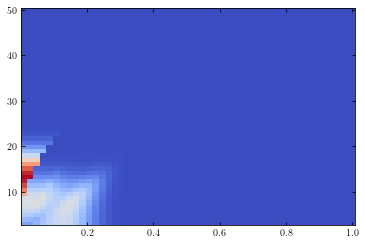

In [54]:
# Load initial conditions for a given experiment, run the model for those conditions 
# and then compare model and experimental data
# fig, ax = plt.subplots()
# ax.plot(exptData.plumeWidth, exptData.distAlongAxis, 'g.', label='natural')
V0, p = loadICsParameters(pathname, exptNo, alpha=0.05, beta=0, m=2)

#p = (0.05,0,0.012**2,2,0)
N = 51
b0Vec = np.linspace(.01, 1, N)   #cm
u0Vec = np.linspace(3, 50, N)   #cm/s
Q0Vec = u0Vec * b0Vec**2
M0Vec = Q0Vec * u0Vec
g = 981 #cm/s²
gp0   = (rhoa0 - rho0) / rhoa0 * g
theta0 = np.pi / 2

objFn = []

sequence = [Q0Vec, M0Vec]

for ind, (Q0, M0) in enumerate(list(product(*sequence))):
    F0 = Q0 * gp0[0]
    V0 = [Q0, M0, F0, theta0]
    
    ####################################
    
    # Initialise an integrator object
    r = ode(derivs).set_integrator('lsoda', nsteps=1e6)
    r.set_initial_value(V0, 0.)
    r.set_f_params(p)
    
    # Define state vector and axial distance
    V = []    # State vector
    s = []    # Axial distance
    V.append(V0)
    s.append(0.)
    
    # Define the individual variables - these will be calculated at run time
    Q, M, F, theta = [], [], [], []
    Q.append(Q0)
    M.append(M0)
    F.append(F0)
    theta.append(theta0)
    
    ####################################
    
    # Set integration domain and step size
    t1 = 30    # Domain of integration 
    dt = .05     # Integration step

    # Integrate, whilst successful, until the domain size is reached
    while r.successful() and r.t < t1 and M[-1] >= 0.:
        r.integrate(r.t + dt)
        V.append(r.y)
        s.append(r.t)
        Q_, M_, F_, theta_ = r.y
        Q.append(Q_)
        M.append(M_)
        F.append(F_)
        theta.append(theta_)
    s = np.array(s)
    V = np.array(V)
    Q = np.array(Q)
    M = np.array(M)
    F = np.array(F)
    
    #######################################
    
    b=Q/np.sqrt(M)/np.sqrt(2)
    u=M/Q
    gp=F/Q
    
    #Interpolate model data to fit z from experiment
    interpObj = interp1d(s, b)
    Vsyn = interpObj(exptData.distAlongAxis)
    Vsyn
    Vexp = exptData.plumeAngle

    objFn.append(objectiveFn(Vexp, Vsyn, p=p))
#     ax.plot(b, s, '-', label=r'$Q_0$=%.0f cm$^3$/s, $M_0$=%.0f cm$^4$/s$^2$' % (Q0, M0))

# ax.set_xlabel('Plume parameter')
# ax.set_ylabel('Plume altitude/[cm]')
# ax.legend()
    
# #ax.legend(loc=5)
# fig.savefig('images/plume_width_data_model.png', dpi=300)

objFn = np.array(objFn).reshape((-1, N))

plt.pcolor(M0Vec, Q0Vec, objFn)

562

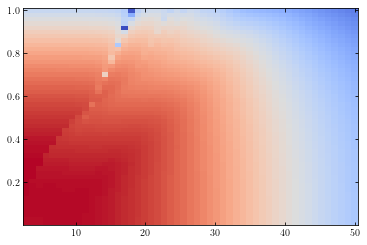

In [63]:
# plt.pcolor(M0Vec, Q0Vec, objFn)

from matplotlib.colors import LogNorm

LN = LogNorm(vmin=objFn.min(), vmax=objFn.max())
plt.pcolor(u0Vec, b0Vec, objFn, norm=LN)

objFn.argmax()

In [64]:
# Calculate the model predictions
# Extract the plume parameters from the state vector
Q     = V[:,0]
M     = V[:,1]
F     = V[:,2]
theta = V[:,3]

# Calculate more intuitive plume parameters (width, speed and specific gravity)
b  = Q / np.sqrt(M)
u  = M / Q
gp = F / Q

xmod, zmod = [0.], [0.]
ds_ = np.diff(s)
for (ds, th) in zip(ds_, theta):
    xmod.append(xmod[-1] + ds * np.cos(th))
    zmod.append(zmod[-1] + ds * np.sin(th))

In [65]:
# Directly compare the plume width and angle for experiment and model
# First, the model data has to be interpolated onto the same grid as the experimental data
from scipy.interpolate import interp1d
# Plume width9
f = interp1d(s, b)
bmod = f(sexp)
# Plume angle
f = interp1d(s, theta)
thmod = f(sexp)

In [67]:
# Calculate an "objective function" which measures the misfit between data and model
# Initially, only use width and angle
Vexp = np.array([bexp, thexp]).T
Vmod = np.array([bmod, thmod]).T
sigV = np.array([sig_bexp, sig_thexp]).T

# The residual between experimental and model data
res = (Vexp - Vmod) / sigV
# objFn = objectiveFn(Vexp.ravel(), Vmod.ravel(), np.diagflat(sigV.ravel())**2, p)

Text(0.5, 1.0, 'Objective fn: 0.000')

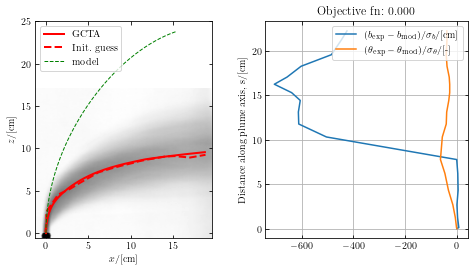

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# On an image of the experimental plume, show the plume trajectories for
# 1) GCTA, 2) our initial guess, 3) the model solution
data, xexp, zexp, extent = loadExptData(exptNo)
if data.mean() < .5:
    data = 1. - data
ax[0].imshow(data, extent=extent, cmap=plt.cm.gray)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$x$/[cm]')
ax[0].set_ylabel(r'$z$/[cm]')
# 1) GCTA
ax[0].plot(xexp, zexp, 'r-', label='GCTA', lw=2)
# 2) our initial guess
ax[0].plot(exptData.axisLocn_x, exptData.axisLocn_y, 'r--', label='Init. guess', lw=2)
# 3) the model solution
ax[0].plot(xmod, zmod, 'g--', label='model', lw=1)
ax[0].set_xlim((extent[:2]))
ax[0].legend(loc=2)

ax[1].plot(res[:,0], sexp, '-', label=r'$(b_{\mathrm{exp}} - b_{\mathrm{mod}})/\sigma_b$/[cm]')
ax[1].plot(res[:,1], sexp, '-', label=r'$(\theta_{\mathrm{exp}} - \theta_{\mathrm{mod}})/\sigma_{\theta}$/[-]')
ax[1].legend(loc=1, fancybox=True, framealpha=.8)
ax[1].grid()
ax[1].set_ylabel('Distance along plume axis, s/[cm]')
9
ax[1].set_title('Objective fn: %.3f' % objFn)

(*Left*) Image of experimental plume with calculated and estimated trajectories.  (*Right*) Difference between experimental (guessed) and model solutions as a function of the distance along the plume axis.  

# To do:
- Make a grid of possible initial conditions and run the model for each case
- Compare these solutions against the experimental data, computing an objective funtion for each case
- Identify which cases produce minima in the objective function

In [10]:
# Uncomment the following line to transform this notebook into a latex file
!jupyter nbconvert --to latex plumeAnalyser.ipynb

[NbConvertApp] Converting notebook plumeAnalyser.ipynb to latex
[NbConvertApp] Support files will be in plumeAnalyser_files/
[NbConvertApp] Making directory plumeAnalyser_files
[NbConvertApp] Writing 36000 bytes to plumeAnalyser.tex


In [11]:
# Now run pdflatex plumeAnalyser from the command line